In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load the dataset
file_path = '/content/World_development_mesurement.xlsx'
data = pd.read_excel(file_path)

# Create a LabelEncoder object
le = LabelEncoder()

# Iterate over the categorical columns and encode them
for column in data.select_dtypes(include='object'):
    data[column] = le.fit_transform(data[column])

# Handling missing values
imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data.select_dtypes(include=['float64', 'int64'])), columns=data.select_dtypes(include=['float64', 'int64']).columns)

# Detect outliers
def detect_outliers(df, features):
    outlier_indices = []
    for feature in features:
        IQR = df[feature].quantile(0.75) - df[feature].quantile(0.25)
        lower_bound = df[feature].quantile(0.25) - 1.5 * IQR
        upper_bound = df[feature].quantile(0.75) + 1.5 * IQR
        outlier_indices.extend(df[~((df[feature] >= lower_bound) & (df[feature] <= upper_bound))].index.tolist())
    return outlier_indices

# Find outlier indices
outlier_indices = detect_outliers(data_imputed, data_imputed.columns)

# Remove outliers
data_cleaned = data_imputed.drop(outlier_indices)

# Reset the index
data_cleaned = data_cleaned.reset_index(drop=True)

# Normalizing the data
scaler = StandardScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(data_cleaned), columns=data_cleaned.columns)

# KMeans Clustering
#optimal_k = 3  # You can adjust this based on the elbow plot
#kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
#data_normalized['Cluster'] = kmeans.fit_predict(data_normalized)




/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

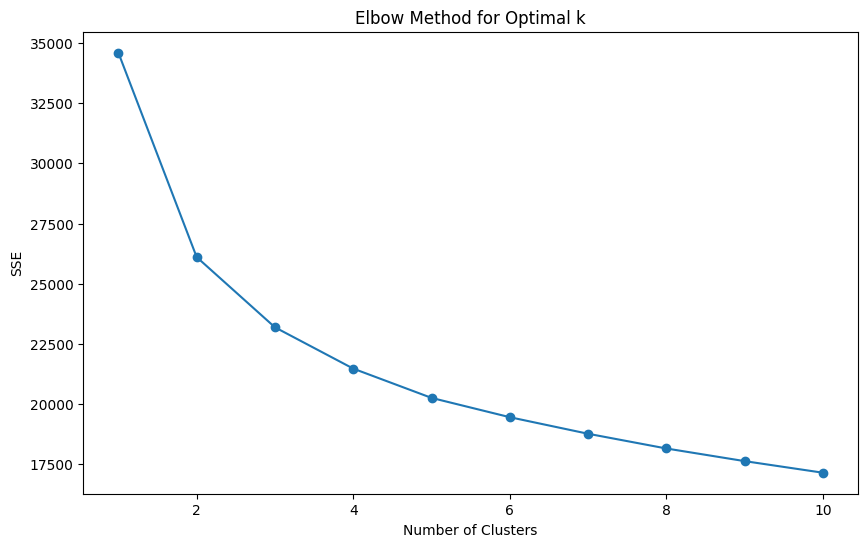

In [19]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns

# Choosing the number of clusters (Elbow Method)
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_normalized)
    sse.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal k')
plt.show()



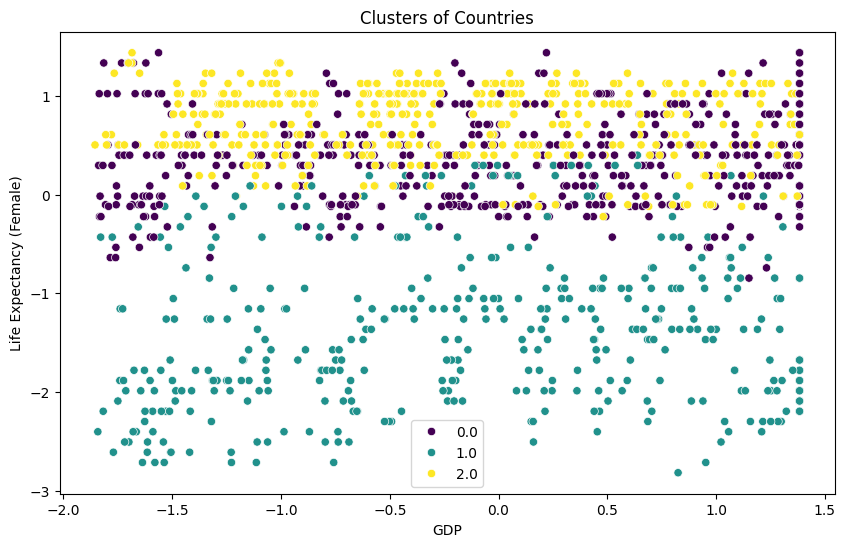

In [20]:
# Applying KMeans with the optimal number of clusters
optimal_k = 3  # For example, if 3 is the optimal number of clusters from the elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)

# Fit and predict on the normalized data, then add the cluster column to the normalized dataframe
data_normalized['Cluster'] = kmeans.fit_predict(data_normalized)

# If there are non-numeric columns, let's add them back to the normalized data, now containing the Cluster column
non_numeric_data = data.select_dtypes(exclude=['float64', 'int64'])
data_final = pd.concat([data_normalized, non_numeric_data.reset_index(drop=True)], axis=1)

# Visualizing the clusters
plt.figure(figsize=(10, 6))
# Removed the leading space in the column name for the y-axis
sns.scatterplot(data=data_final, x='GDP', y='Life Expectancy Female', hue='Cluster', palette='viridis')
plt.title('Clusters of Countries')
plt.xlabel('GDP')
plt.ylabel('Life Expectancy (Female)')
plt.legend()
plt.show()

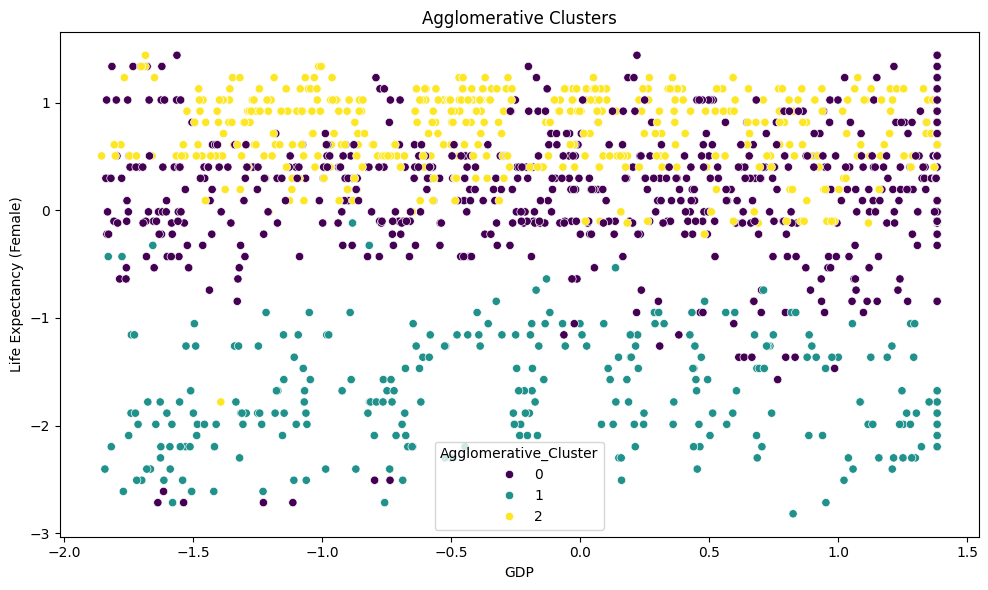

In [21]:
# Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=3)

# Select numeric columns and handle missing values (replace with 0 for this example)
numeric_data = data_final.select_dtypes(['float64', 'int64']).fillna(0)  # Replace NaNs with 0

# Fit and predict on the numeric data with NaNs handled
data_final['Agglomerative_Cluster'] = agg.fit_predict(numeric_data)

# Visualizing the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_final, x='GDP', y='Life Expectancy Female', hue='Agglomerative_Cluster', palette='viridis')
plt.title('Agglomerative Clusters')
plt.xlabel('GDP')
plt.ylabel('Life Expectancy (Female)')
plt.tight_layout()
plt.show()

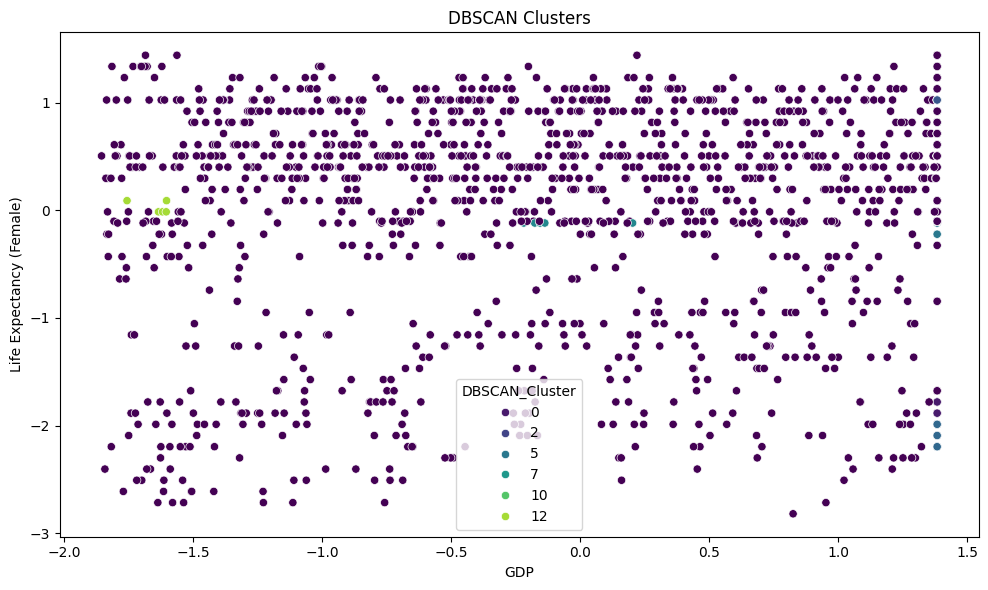

In [22]:
# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Select numeric columns and handle missing values (replace with 0 for this example)
numeric_data = data_final.select_dtypes(['float64', 'int64']).fillna(0)  # Replace NaNs with 0 if necessary

# Fit and predict on the numeric data with NaNs handled
data_final['DBSCAN_Cluster'] = dbscan.fit_predict(numeric_data)  # Use numeric_data here

#plt.subplot(1, 3, 3)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_final, x='GDP', y='Life Expectancy Female', hue='DBSCAN_Cluster', palette='viridis')
plt.title('DBSCAN Clusters')
plt.xlabel('GDP')
plt.ylabel('Life Expectancy (Female)')
plt.tight_layout()
plt.show()

In [23]:
from sklearn.metrics import silhouette_score

# Select only the rows in 'data_final' that correspond to the indices in 'data_normalized'
data_final_subset = data_final.loc[data_normalized.index]

# Compute silhouette scores using the subset of 'data_final'
kmeans_silhouette = silhouette_score(data_normalized, data_final_subset['Cluster'])
agg_silhouette = silhouette_score(data_normalized, data_final_subset['Agglomerative_Cluster'])
dbscan_silhouette = silhouette_score(data_normalized, data_final_subset['DBSCAN_Cluster'])

print(f'K-Means Silhouette Score: {kmeans_silhouette}')
print(f'Agglomerative Clustering Silhouette Score: {agg_silhouette}')
print(f'DBSCAN Silhouette Score: {dbscan_silhouette}')


K-Means Silhouette Score: 0.19118395701208876
Agglomerative Clustering Silhouette Score: 0.17550092212533322
DBSCAN Silhouette Score: -0.17158491088260408


Accuracy: 0.9568106312292359

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       134
           1       0.99      0.96      0.97        74
           2       0.95      0.95      0.95        93

    accuracy                           0.96       301
   macro avg       0.96      0.96      0.96       301
weighted avg       0.96      0.96      0.96       301


Confusion Matrix:
 [[129   0   5]
 [  3  71   0]
 [  4   1  88]]


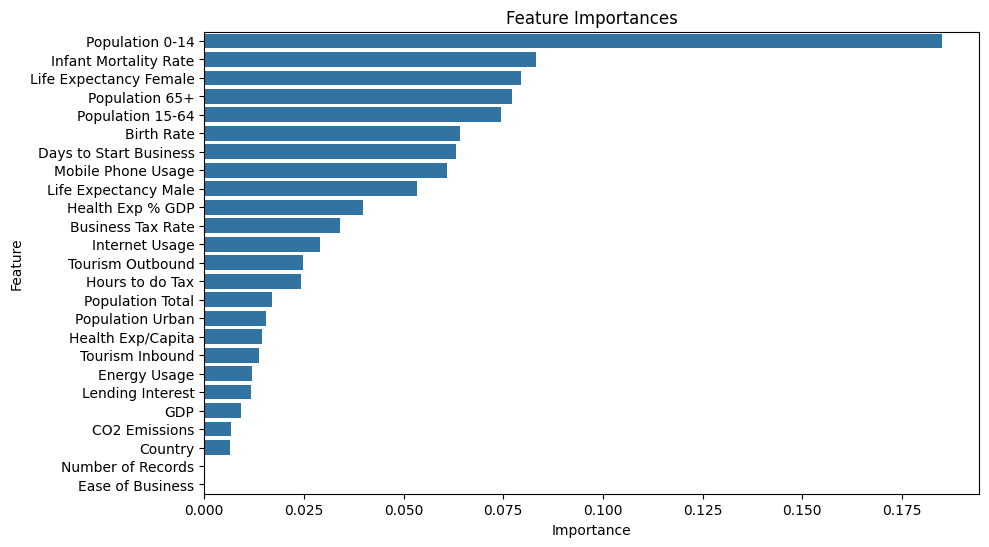

In [24]:
# Prepare the data for Random Forest
X = data_normalized.drop('Cluster', axis=1)
y = data_normalized['Cluster']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predictions
y_pred = rf_classifier.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Feature Importances
importances = rf_classifier.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plotting Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances')
plt.show()

In [25]:
accuracy = accuracy_score(y_test, y_pred)

if accuracy > 0.8:  # Adjust the threshold as needed
    print("The model has high accuracy. Consider these suggestions:")
    # Print suggestions for high accuracy scenario
    print("- Focus on fine-tuning hyperparameters for further improvement.")
    print("- Explore more complex models if necessary.")
elif accuracy > 0.6:
    print("The model has moderate accuracy. Consider these suggestions:")
    # Print suggestions for moderate accuracy scenario
    print("- Investigate feature engineering techniques to improve performance.")
    print("- Try different algorithms to see if they yield better results.")
else:
    print("The model has low accuracy. Consider these suggestions:")
    # Print suggestions for low accuracy scenario
    print("- Re-evaluate your data preprocessing steps.")
    print("- Collect more data if possible.")
    print("- Simplify the model to avoid overfitting.")


The model has high accuracy. Consider these suggestions:
- Focus on fine-tuning hyperparameters for further improvement.
- Explore more complex models if necessary.


In [26]:
# Calculate cluster profiles
cluster_profiles = data_final.groupby('Cluster')[['Birth Rate', 'Business Tax Rate', 'CO2 Emissions', 'Country', 'Days to Start Business',
                                                   'Ease of Business', 'Energy Usage', 'GDP', 'Health Exp % GDP', 'Health Exp/Capita',
                                                   'Infant Mortality Rate', 'Internet Usage', 'Life Expectancy Female', 'Life Expectancy Male',
                                                   'Mobile Phone Usage', 'Number of Records', 'Population 0-14', 'Population 15-64',
                                                   'Population 65+', 'Population Total', 'Population Urban', 'Tourism Inbound',
                                                   'Tourism Outbound']].mean()

# Print suggestions for each cluster
for cluster in cluster_profiles.index:
    print(f"\nSuggestions for Cluster {cluster}:")
    for column in cluster_profiles.columns:
        value = cluster_profiles.loc[cluster, column]
        # Customize suggestions based on column and value
        if column == 'GDP':
            if value > cluster_profiles['GDP'].mean():
                print(f"  - Maintain high GDP growth through sustainable economic policies.")
            else:
                print(f"  - Prioritize investments to boost GDP and economic development.")
        elif column == 'Life Expectancy Female':
            if value > cluster_profiles['Life Expectancy Female'].mean():
                print(f"  - Continue investing in healthcare and social programs to maintain high life expectancy for women.")
            else:
                print(f"  - Focus on improving healthcare access and quality to increase female life expectancy.")
        elif column == 'Infant Mortality Rate':
            if value < cluster_profiles['Infant Mortality Rate'].mean():
                print(f"  - Sustain efforts to keep infant mortality rates low through healthcare and maternal support programs.")
            else:
                print(f"  - Implement targeted interventions to reduce infant mortality rates, focusing on prenatal care and child health.")
        elif column == 'CO2 Emissions':
            if value < cluster_profiles['CO2 Emissions'].mean():
                print(f"  - Continue pursuing sustainable energy policies to maintain low CO2 emissions.")
            else:
                print(f"  - Adopt stricter environmental regulations and invest in renewable energy sources to reduce CO2 emissions.")
        elif column == 'Ease of Business':
            if value > cluster_profiles['Ease of Business'].mean():
                print(f"  - Continue streamlining business regulations to maintain a favorable business environment.")
            else:
                print(f"  - Reduce bureaucratic hurdles and improve the ease of doing business to attract investment and foster entrepreneurship.")
        elif column == 'Health Exp % GDP':
            if value > cluster_profiles['Health Exp % GDP'].mean():
                print(f"  - Ensure efficient allocation of healthcare resources while maintaining a high level of investment.")
            else:
                print(f"  - Increase healthcare spending as a percentage of GDP to improve health outcomes.")
        elif column == 'Internet Usage':
            if value > cluster_profiles['Internet Usage'].mean():
                print(f"  - Leverage high internet penetration to promote digital inclusion and economic growth.")
            else:
                print(f"  - Invest in expanding internet infrastructure and access to bridge the digital divide.")
        elif column == 'Birth Rate':
            if value > cluster_profiles['Birth Rate'].mean():
                print(f"  - Consider implementing family planning programs to manage population growth.")
            else:
                print(f"  - Explore policies to encourage higher birth rates if desired for demographic reasons.")
        elif column == 'Business Tax Rate':
            if value > cluster_profiles['Business Tax Rate'].mean():
                print(f"  - Evaluate the impact of business tax rates on economic activity and consider potential adjustments.")
            else:
                print(f"  - Maintain a competitive business tax environment to attract investment.")
        elif column == 'Days to Start Business':
            if value > cluster_profiles['Days to Start Business'].mean():
                print(f"  - Streamline the process for starting businesses to reduce bureaucratic delays.")
            else:
                print(f"  - Continue simplifying business registration procedures to encourage entrepreneurship.")
        elif column == 'Energy Usage':
            if value > cluster_profiles['Energy Usage'].mean():
                print(f"  - Promote energy efficiency measures and invest in renewable energy sources to reduce overall consumption.")
            else:
                print(f"  - Ensure access to reliable and affordable energy to support economic development.")




Suggestions for Cluster 0.0:
  - Explore policies to encourage higher birth rates if desired for demographic reasons.
  - Evaluate the impact of business tax rates on economic activity and consider potential adjustments.
  - Adopt stricter environmental regulations and invest in renewable energy sources to reduce CO2 emissions.
  - Streamline the process for starting businesses to reduce bureaucratic delays.
  - Reduce bureaucratic hurdles and improve the ease of doing business to attract investment and foster entrepreneurship.
  - Promote energy efficiency measures and invest in renewable energy sources to reduce overall consumption.
  - Maintain high GDP growth through sustainable economic policies.
  - Increase healthcare spending as a percentage of GDP to improve health outcomes.
  - Sustain efforts to keep infant mortality rates low through healthcare and maternal support programs.
  - Invest in expanding internet infrastructure and access to bridge the digital divide.
  - Contin

In [27]:

# Print suggestions for each cluster
for cluster in cluster_profiles.index:
    print(f"\nSuggestions for Cluster {cluster}:")
    for column in cluster_profiles.columns:
        value = cluster_profiles.loc[cluster, column]
        # Customize suggestions based on column and value
        if column == 'GDP':
            if value > cluster_profiles['GDP'].mean():
                print(f"  - Maintain high GDP growth through sustainable economic policies.")
            else:
                print(f"  - Prioritize investments to boost GDP and economic development.")
        elif column == 'Life Expectancy Female':
            if value > cluster_profiles['Life Expectancy Female'].mean():
                print(f"  - Continue investing in healthcare and social programs to maintain high life expectancy for women.")
            else:
                print(f"  - Focus on improving healthcare access and quality to increase female life expectancy.")
        elif column == 'Infant Mortality Rate':
            if value < cluster_profiles['Infant Mortality Rate'].mean():
                print(f"  - Sustain efforts to keep infant mortality rates low through healthcare and maternal support programs.")
            else:
                print(f"  - Implement targeted interventions to reduce infant mortality rates, focusing on prenatal care and child health.")
        elif column == 'CO2 Emissions':
            if value < cluster_profiles['CO2 Emissions'].mean():
                print(f"  - Continue pursuing sustainable energy policies to maintain low CO2 emissions.")
            else:
                print(f"  - Adopt stricter environmental regulations and invest in renewable energy sources to reduce CO2 emissions.")
        elif column == 'Ease of Business':
            if value > cluster_profiles['Ease of Business'].mean():
                print(f"  - Continue streamlining business regulations to maintain a favorable business environment.")
            else:
                print(f"  - Reduce bureaucratic hurdles and improve the ease of doing business to attract investment and foster entrepreneurship.")
        elif column == 'Health Exp % GDP':
            if value > cluster_profiles['Health Exp % GDP'].mean():
                print(f"  - Ensure efficient allocation of healthcare resources while maintaining a high level of investment.")
            else:
                print(f"  - Increase healthcare spending as a percentage of GDP to improve health outcomes.")
        elif column == 'Internet Usage':
            if value > cluster_profiles['Internet Usage'].mean():
                print(f"  - Leverage high internet penetration to promote digital inclusion and economic growth.")
            else:
                print(f"  - Invest in expanding internet infrastructure and access to bridge the digital divide.")
        elif column == 'Business Tax Rate':
            if value < cluster_profiles['Business Tax Rate'].mean():
                print(f"  - Consider maintaining competitive business tax rates to attract investment.")
            else:
                print(f"  - Evaluate the potential impact of lowering business tax rates to stimulate economic activity.")
        elif column == 'Energy Usage':
            if value < cluster_profiles['Energy Usage'].mean():
                print(f"  - Promote energy efficiency and conservation practices to maintain low energy consumption.")
            else:
                print(f"  - Explore strategies to reduce energy consumption, including investments in renewable energy and efficiency programs.")
        elif column == 'Health Exp/Capita':
            if value > cluster_profiles['Health Exp/Capita'].mean():
                print(f"  - Continue investing in healthcare infrastructure and services to maintain high per capita health expenditure.")
            else:
                print(f"  - Increase per capita health expenditure to improve access to quality healthcare services.")
        elif column == 'Mobile Phone Usage':
            if value > cluster_profiles['Mobile Phone Usage'].mean():
                print(f"  - Leverage high mobile phone penetration for mobile banking, education, and other developmental initiatives.")
            else:
                print(f"  - Expand mobile phone infrastructure and access to enhance communication and connectivity.")
        elif column == 'Population Urban':
            if value > cluster_profiles['Population Urban'].mean():
                print(f"  - Address challenges associated with high urbanization, such as infrastructure development and housing.")
            else:
                print(f"  - Invest in urban development and infrastructure to support sustainable urbanization.")
        elif column == 'Tourism Inbound':
            if value > cluster_profiles['Tourism Inbound'].mean():
                print(f"  - Maintain a thriving tourism sector through sustainable tourism practices and infrastructure development.")
            else:
                print(f"  - Develop tourism infrastructure and promote attractions to increase inbound tourism.")
        elif column == 'Tourism Outbound':
            if value > cluster_profiles['Tourism Outbound'].mean():
                print(f"  - Encourage domestic tourism and explore ways to balance outbound tourism with domestic economic benefits.")
            else:
                print(f"  - Facilitate outbound tourism to promote cultural exchange and economic opportunities.")
        # Add similar conditional suggestions for other relevant columns



Suggestions for Cluster 0.0:
  - Evaluate the potential impact of lowering business tax rates to stimulate economic activity.
  - Adopt stricter environmental regulations and invest in renewable energy sources to reduce CO2 emissions.
  - Reduce bureaucratic hurdles and improve the ease of doing business to attract investment and foster entrepreneurship.
  - Explore strategies to reduce energy consumption, including investments in renewable energy and efficiency programs.
  - Maintain high GDP growth through sustainable economic policies.
  - Increase healthcare spending as a percentage of GDP to improve health outcomes.
  - Continue investing in healthcare infrastructure and services to maintain high per capita health expenditure.
  - Sustain efforts to keep infant mortality rates low through healthcare and maternal support programs.
  - Invest in expanding internet infrastructure and access to bridge the digital divide.
  - Continue investing in healthcare and social programs to mai